In [5]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


from scipy import optimize
from tensorflow.keras import layers

In [6]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
myfile = requests.get(url)

In [7]:
open('data.xlsx', 'wb').write(myfile.content)

23715344

In [8]:
xls_file = pd.ExcelFile('data.xlsx')
df = xls_file.parse('Online Retail')

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
revenue_by_country = df.groupby('Country', as_index=False).agg({"Revenue": "sum"})
revenue_ranking_by_country = revenue_by_country.sort_values('Revenue', ascending=False)
revenue_ranking_by_country.head()

,Country,Revenue
36,United Kingdom,8.187806e+06
24,Netherlands,2.846615e+05
10,EIRE,2.632768e+05
14,Germany,2.216982e+05
13,France,1.974039e+05


In [11]:
df['Date'] = df['InvoiceDate'].dt.date
sales = df.groupby('Date', as_index=False)['Revenue'].sum()
sales.head()

,Date,Revenue
0,2010-12-01,58635.56
1,2010-12-02,46207.28
2,2010-12-03,45620.46
3,2010-12-05,31383.95
4,2010-12-06,53860.18


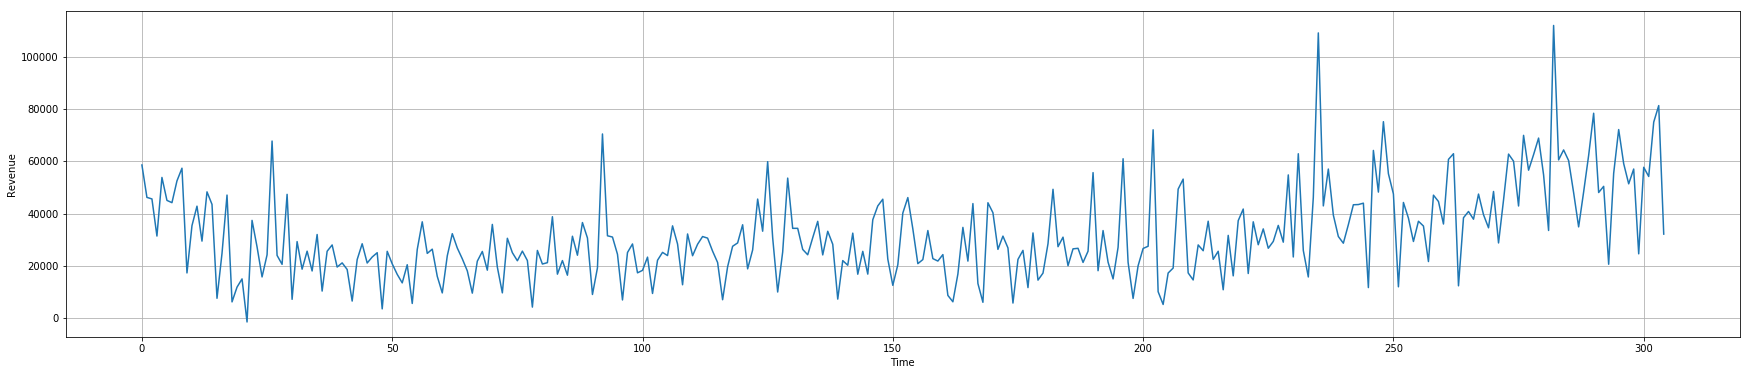

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time,series)
    plt.xlabel("Time")
    plt.ylabel("Revenue")
    plt.grid(True)


series = np.array(sales['Revenue'])
time = np.array(sales.index)
plt.figure(figsize=(30, 6))
plot_series(time, series)

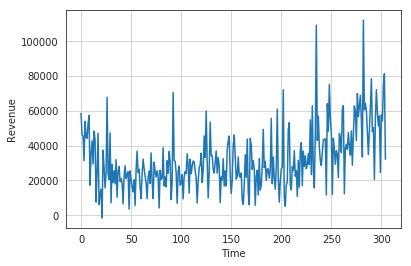

In [19]:

plot_series(time, series)

In [14]:
df.corr()

,Quantity,UnitPrice,CustomerID,Revenue
Quantity,1.000000,-0.001235,-0.003600,0.886681
UnitPrice,-0.001235,1.000000,-0.004560,-0.162029
CustomerID,-0.003600,-0.004560,1.000000,-0.002274
Revenue,0.886681,-0.162029,-0.002274,1.000000


In [15]:
df['CustomerID'].corr(df['Revenue'])

-0.0022741225685228533

In [16]:
mask = np.zeros_like(df.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True
mask

array([[1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

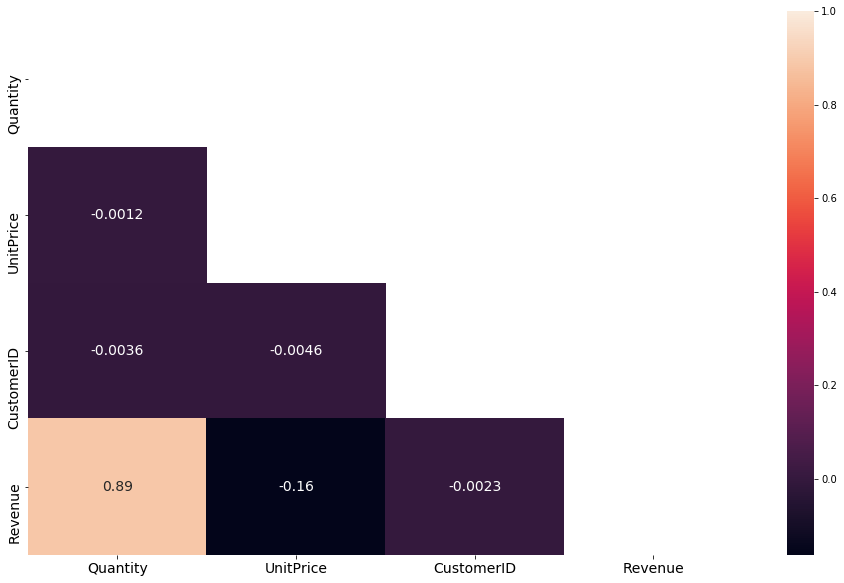

In [17]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), mask=mask, annot=True, annot_kws={"size": 14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, RNN,Dense,Dropout,Activation
import numpy as np
import keras



import numpy as np

from keras.models import load_model
from tensorflow import keras


Using TensorFlow backend.


In [21]:

from tensorflow.python import keras


from tensorflow.python.eager import test
from tensorflow.python.keras import testing_utils
from tensorflow.python.keras.optimizer_v2 import gradient_descent as gradient_descent_keras
from tensorflow.python.keras.optimizer_v2 import rmsprop as rmsprop_keras
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.ops.parsing_ops import gen_parsing_ops
from tensorflow_estimator.python.estimator import keras as keras_lib
from tensorflow_estimator.python.estimator import run_config as run_config_lib

In [26]:
split_time = 280
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


split_time = 280
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 10
batch_size = 4
shuffle_buffer_size = 10

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

In [16]:
x_train.shape


(280,)

In [32]:
x_vaild.shape

NameError: name 'x_vaild' is not defined

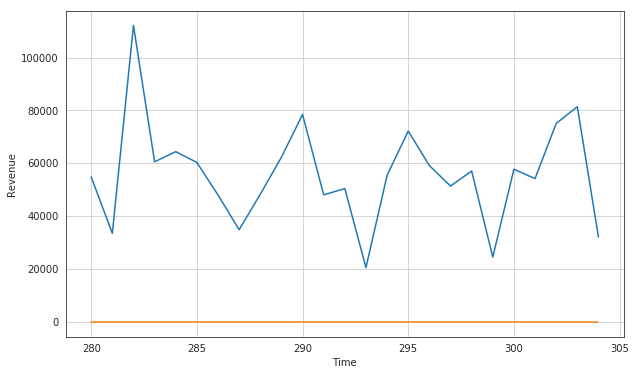

In [28]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)